# Notebook Contents

- [Imports](#Imports)
- [Data](#Data)
- [Features](#Features)
- [Random Forest](#Random-Forest-Regression-Model)
    - [Fastball RHP](#Fastball-RHP)
    - [Fastball LHP](#Fastball-LHP)
    - [Breaking Ball RHP](#Breaking-Ball-RHP)
    - [BreakingBall LHP](#Breaking-Ball-LHP)
    - [Off-Speed RHP](#off-Speed-RHP)
    - [Off-Speed LHP](#Off-Speed-LHP)

# Imports

In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Rectangle

import warnings
warnings.filterwarnings('ignore')

# Data

In [2]:
data = pd.read_csv('../data/model-pitches-rv.csv', index_col = [0])
data.drop(columns = ['plate_x', 'release_pos_x'], inplace = True)
data.rename(columns = {'pfx_-x': 'pfx_x', 
                       'plate_-x': 'plate_x', 
                       'release_pos_-x': 'release_pos_x'}, 
            inplace = True)

pd.set_option('max_columns', None)
print(data.shape)
data.head()

(705396, 68)


,player_name,p_throws,pitch_type,velo,spin_rate,spin_axis,pfx_x,pfx_z,bauer_units,effective_speed,release_pos_x,release_pos_z,release_extension,release_pos_y,plate_x,plate_z,type,balls,strikes,pitch_count,delta_run_exp,stand,bb_type,description,events,hit_distance_sc,exit_velo,launch_angle,launch_speed_angle,woba_value,woba_denom,xba,xwoba,babip_value,iso_value,at_bat_number,pitch_number,inning,inning_topbot,home_score,away_score,post_home_score,post_away_score,on_1b,on_2b,on_3b,outs_when_up,arm_angle,slot,is_strike,is_ball,final_pitch_ab,out_to_end_inning,home_runs,away_runs,runs,re,re_change,re_end_state,re24,lin_weight_above_avg,lin_weight_above_outs,woba_scale,lin_weights_above_avg_scale,lin_weights_above_outs_scale,woba,wraa_change,rv
0,"Smith, Will",L,FF,92.3,2330.0,148.0,-8.28,16.56,25.243770,92.8,-1.40,6.80,6.5,54.03,0.69,2.83,X,1,2,1-2,-0.073,R,ground_ball,hit_into_play,field_out,13.0,95.2,-13.0,2.0,0.0,1.0,0.174,0.158,0.0,0.0,61,4,9,0,5,0,5,0,0,0,0,2,36.0,1,1,0,1,1,0,0,0,0.11,-0.11,0.00,-0.11,-0.271,0.0,1.209,-0.328,0.0,0.222,-0.152,-0.262
1,"Smith, Will",L,SL,80.6,2254.0,315.0,9.24,5.76,27.965261,81.2,-1.60,6.64,6.4,54.15,0.71,2.62,S,1,1,1-1,-0.027,R,NaN,strike,NaN,108.0,75.3,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,3,9,0,5,0,5,0,0,0,0,2,45.8,2,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.300,-0.053,-0.053
2,"Smith, Will",L,CU,75.5,1940.0,328.0,7.80,-6.12,25.695364,75.2,-1.46,6.88,6.2,54.34,0.04,2.46,S,1,0,1-0,-0.020,R,NaN,strike,NaN,157.0,83.5,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,2,9,0,5,0,5,0,0,0,0,2,38.4,1,1,0,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.356,-0.038,-0.038
3,"Smith, Will",L,CU,75.0,2017.0,330.0,8.28,-8.28,26.893333,74.5,-1.53,6.83,5.9,54.61,-2.10,3.89,B,0,0,0-0,0.016,R,NaN,ball,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61,1,9,0,5,0,5,0,0,0,0,2,38.4,1,0,1,0,0,0,0,0,0.11,0.00,0.11,0.00,NaN,NaN,1.209,0.000,0.0,0.314,0.028,0.028
4,"Smith, Will",L,FF,91.2,2281.0,143.0,-7.56,15.36,25.010965,90.9,-1.49,6.66,6.3,54.15,0.31,2.80,X,1,0,1-0,-0.189,L,ground_ball,hit_into_play,field_out,9.0,93.3,-18.0,2.0,0.0,1.0,0.100,0.090,0.0,0.0,60,2,9,0,5,0,5,0,0,0,0,1,36.0,1,1,0,1,0,0,0,0,0.29,-0.18,0.11,-0.18,-0.271,0.0,1.209,-0.328,0.0,0.356,-0.038,-0.218


In [3]:
dundas = pd.read_csv('../data/')
dundas.rename(columns = dundas.iloc[3], inplace = True)
dundas.drop(columns = ['Pitch ID', 'Unique ID', 'Device Serial Number'], index = [0, 1, 2, 3, 19], 
             inplace = True)

col_dict = ({'Pitch Type': 'pitch_type',
             'Is Strike': 'is_strike',
             'Strike Zone Side': 'plate_x',
             'Strike Zone Height': 'plate_z',
             'Velocity': 'velo',
             'Total Spin': 'spin_rate',
             'True Spin (release)': 'true_spin',
             'Spin Efficiency (release)': 'spin_eff',
             'Spin Direction': 'spin_dir',
             'Spin Confidence': 'spin_confidence',
             'HB (spin)': 'pfx_x',
             'VB (spin)': 'pfx_z',
             'Release Side': 'release_pos_x',
             'Release Height': 'release_pos_z',
             'Horizontal Angle': 'horizontal_angle',
             'Release Angle': 'release_angle',
             'Gyro Degree (deg)': 'gyro_deg'
              })

dundas.rename(columns = col_dict, inplace = True)
print(dundas.shape)
dundas.head()

(62, 19)


,No,Date,pitch_type,is_strike,plate_x,plate_z,velo,spin_rate,true_spin,spin_eff,spin_dir,spin_confidence,pfx_z,pfx_x,horizontal_angle,release_angle,release_pos_z,release_pos_x,gyro_deg
4,1,Tue Apr 19 2022 7:48:11 PM,Fastball,N,11.28,17.38,89.22,2114.7,1999,94.5,1:8,1,15.9,10.7,-2.18,-2.29,4.87,1.93,19.04
5,2,Tue Apr 19 2022 7:48:22 PM,Fastball,N,23.54,37.81,89.37,2278.9,2174.5,95.4,1:6,0.9,17.2,11.4,-1.48,-0.74,4.90,2.01,17.42
6,3,Tue Apr 19 2022 7:48:31 PM,Fastball,Y,-1.79,30.74,89.47,2327.2,2176.9,93.5,0:52,0.9,17.8,8.7,-2.63,-1.49,4.70,1.73,20.71
7,4,Tue Apr 19 2022 7:49:15 PM,Fastball,Y,3.36,38.96,91.1,2455.1,2165.9,88.2,0:48,0.9,18.6,8.3,-1.97,-0.50,4.81,1.83,28.09
8,5,Tue Apr 19 2022 7:50:16 PM,Fastball,Y,-2.25,26.57,91.56,2266.1,2032.1,89.7,0:54,0.9,16.4,8.3,-2.76,-1.67,4.71,1.76,26.27


In [4]:
dundas.pitch_type.value_counts()

Fastball           30
Slider             14
ChangeUp           11
CurveBall           6
TwoSeamFastball     1
Name: pitch_type, dtype: int64

### Features

**Independent Variables:** Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

**Dependent Variable:** Run Value

In [7]:
features = data[['player_name', 'p_throws', 'pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                 'release_pos_x', 'release_pos_z', 'rv']]
dundas_features = dundas[['pitch_type', 'velo', 'spin_rate', 'pfx_x', 'pfx_z', 
                            'release_pos_x', 'release_pos_z']]

In [8]:
fastball = features[features['pitch_type'].isin(['FF', 'FC', 'SI'])]
breaking_ball = features[features['pitch_type'].isin(['SL', 'CU', 'KC'])]
offspeed = features[features['pitch_type'].isin(['CH', 'FS'])]
rhp = features.loc[features['p_throws'] == 'R']
lhp = features.loc[features['p_throws'] == 'L']
rhp_fastball = fastball.loc[fastball['p_throws'] == 'R']
lhp_fastball = fastball.loc[fastball['p_throws'] == 'L']
rhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'R']
lhp_breaking_ball = breaking_ball.loc[breaking_ball['p_throws'] == 'L']
rhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'R']
lhp_offspeed = offspeed.loc[offspeed['p_throws'] == 'L']
ff_r = rhp.loc[rhp['pitch_type'] == 'FF']
ff_l = lhp.loc[lhp['pitch_type'] == 'FF']
fc_r = rhp.loc[rhp['pitch_type'] == 'FC']
fc_l = lhp.loc[lhp['pitch_type'] == 'FC']
si_r = rhp.loc[rhp['pitch_type'] == 'SI']
si_l = lhp.loc[lhp['pitch_type'] == 'SI']
sl_r = rhp.loc[rhp['pitch_type'] == 'SL']
sl_l = lhp.loc[lhp['pitch_type'] == 'SL']
cu_r = rhp.loc[rhp['pitch_type'] == 'CU']
cu_l = lhp.loc[lhp['pitch_type'] == 'CU']
ch_r = rhp.loc[rhp['pitch_type'] == 'CH']
ch_l = lhp.loc[lhp['pitch_type'] == 'CH']

# Random Forest Regression Model

## Fastball RHP Grouped

#### 4-Seam, Cutter, Sinker

In [9]:
print('Baseline RHP Fastball RunValue Accuracy Score:', round(rhp_fastball.rv.mean(), 2))

Baseline RHP Fastball RunValue Accuracy Score: -0.02


In [10]:
features_fastball_r = rhp_fastball.select_dtypes([np.number])
X = features_fastball_r.drop(columns = ['rv'])
y = features_fastball_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_fastball_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_fastball_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_fastball_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_fastball_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.04
Test RMSE: 0.282
Test MAE: 0.159 

R2 Score: 0.632
RMSE: 0.168
MAE: 0.085


In [11]:
fastball_rhp = rhp_fastball.copy()
fastball_rhp['xRV'] = pred
fastball_rhp['xRV'] = round(fastball_rhp['xRV'], 3)
fastball_rhp['FF_count'] = [1 if x == 'FF' else 0 for x in rhp_fastball['pitch_type']]
fastball_rhp['SI_count'] = [1 if x == 'SI' else 0 for x in rhp_fastball['pitch_type']]
fastball_rhp['FC_count'] = [1 if x == 'FC' else 0 for x in rhp_fastball['pitch_type']]

ff_bucket_dundas = fastball_rhp.loc[(fastball_rhp['velo'] >= 88.9) & (fastball_rhp['velo'] <= 93.1)]

fastball_rhp.xRV.describe()

count    283224.000000
mean         -0.019230
std           0.157347
min          -1.329000
25%          -0.061000
50%          -0.022000
75%           0.018000
max           2.309000
Name: xRV, dtype: float64

### xRV Table

Velocity, Spin Rate, HB, VB, Release Side, Release Height, Arm Angle, Release Extension

In [12]:
dundas_ff = dundas_features[dundas_features['pitch_type'].isin(['Fastball', 'TwoSeamFastball'])]
dundas_ff.head()
dundas_ff.velo.min(), dundas_ff.velo.max()

('89.22', '92.8')

In [13]:
dundas_ff.drop(columns = ['pitch_type'], inplace = True)
pred_dundas_ff = rf.predict(dundas_ff)
dundas_ff['xRV'] = pred_dundas_ff
print(dundas_ff.shape)
dundas_ff.sort_values(by = 'xRV', ascending=False).head()

(31, 7)


,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
63,89.89,2411.6,7.9,17.6,1.28,5.00,0.22730
36,89.33,2319.4,10.5,17.7,1.31,5.03,0.10822
7,91.1,2455.1,8.3,18.6,1.83,4.81,0.10550
59,90.89,2316.7,8.6,16.6,1.33,5.01,0.07742
46,90.46,2398.9,7.4,16.9,1.43,5.00,0.06792


In [14]:
dundas_ff.describe()

,xRV
count,31.000000
mean,-0.003670
std,0.078615
min,-0.138890
25%,-0.051885
50%,-0.015870
75%,0.047010
max,0.227300


### RHP Fastball xRV by HB & VB

RHP Fastball Avg xRunValue: -0.02


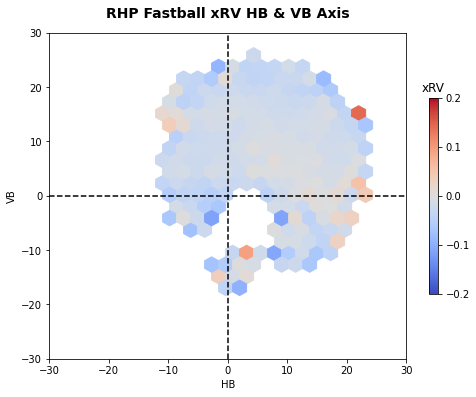

In [18]:
plt.figure(figsize = (8, 6))
plt.hexbin(fastball_rhp['pfx_x'], fastball_rhp['pfx_z'], C = fastball_rhp['xRV'], cmap = 'coolwarm', 
           mincnt = 10, gridsize = 20)
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Fastball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15)
print('RHP Fastball Avg xRunValue:', round(fastball_rhp.xRV.mean(), 2))

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RHP Fastball Avg xRunValue 89-93 mph: -0.01
Feldman Fastball Avg xRunValue 89-93 mph: 0.0


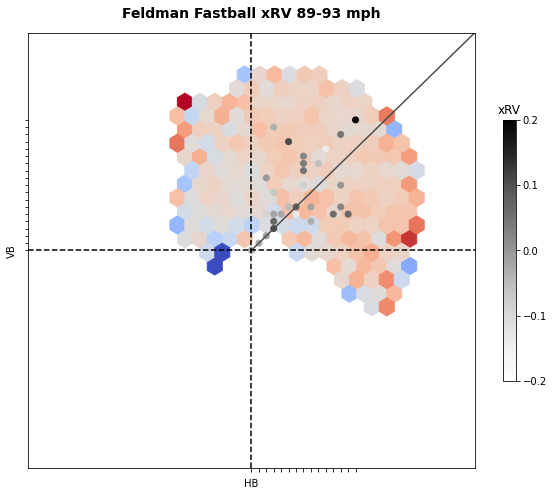

In [19]:
plt.figure(figsize = (10, 8))

plt.hexbin(ff_bucket_dundas['pfx_x'], ff_bucket_dundas['pfx_z'], C = ff_bucket_dundas['xRV'], 
                cmap = 'coolwarm', mincnt = 10, gridsize = 20)
plt.scatter(dundas_ff['pfx_x'],dundas_ff['pfx_z'], c = dundas_ff['xRV'], cmap = 'Greys')
#sns.color_palette("light:black", as_cmap=True)
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([]), ax.axes.yaxis.set_ticklabels([])
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Dundas Fastball xRV 89-93 mph', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue 89-93 mph:', round(ff_bucket_dundas.xRV.mean(), 2))
print('Dundas Fastball Avg xRunValue 89-93 mph:', abs(round(dundas_ff.xRV.mean(), 2)))

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


RHP Fastball Avg xRunValue 82-95 mph: -0.01
Steinfort Fastball Avg xRunValue 82-95 mph: 0.01


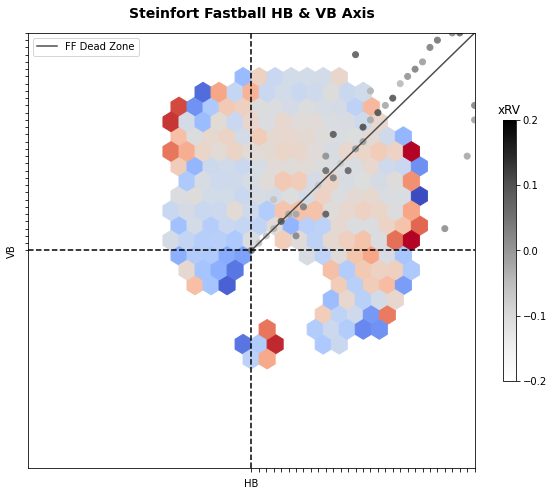

In [20]:
plt.figure(figsize = (10, 8))

plt.hexbin(ff_bucket_steinfort['pfx_x'], ff_bucket_steinfort['pfx_z'], C = ff_bucket_steinfort['xRV'], 
                cmap = 'coolwarm', mincnt = 10, gridsize = 20)
plt.scatter(steinfort_ff['pfx_x'], steinfort_ff['pfx_z'], c = steinfort_ff['xRV'], cmap = 'Greys')
plt.plot([0, 30], [0, 30], ls="-", c=".3", label = 'Fastball Dead Zone')
cb = plt.colorbar(ticks = [-.2, -.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([]), ax.axes.yaxis.set_ticklabels([])
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--'), plt.legend()
plt.title('Steinfort Fastball HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Fastball Avg xRunValue 82-95 mph:', round(ff_bucket_steinfort.xRV.mean(), 2))
print('Steinfort Fastball Avg xRunValue 82-95 mph:', abs(round(steinfort_ff.xRV.mean(), 2)))

## Breaking Ball RHP

#### Slider, Curveball, Knuckle Curve

In [21]:
print('Baseline RHP Breaking Ball RunValue Accuracy Score:', round(rhp_breaking_ball.rv.mean(), 2))

Baseline RHP Breaking Ball RunValue Accuracy Score: -0.04


In [22]:
features_bb_r = rhp_breaking_ball.select_dtypes([np.number])
X = features_bb_r.drop(columns = ['rv'])
y = features_bb_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_bb_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Test Score:', round((metrics.r2_score(y_test, pred_bb_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_bb_r)), 3))
print('MAE:', round(metrics.mean_absolute_error(y_test, pred_bb_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Test Score: -0.036
Test RMSE: 0.275
MAE: 0.158 

R2 Score: 0.633
Test RMSE: 0.164
MAE: 0.085


### RHP Breaking Ball RV

In [3]:
rhp_bb = rhp_breaking_ball.copy()
rhp_bb['xRV'] = pred
rhp_bb['xRV'] = round(rhp_bb['xRV'], 3)
rhp_bb['SL_count'] = [1 if x == 'SL' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['CU_count'] = [1 if x == 'CU' else 0 for x in rhp_bb['pitch_type']]
rhp_bb['KC_count'] = [1 if x == 'KC' else 0 for x in rhp_bb['pitch_type']]

bb_bucket_dundas = rhp_bb.loc[(rhp_bb['velo'] >= 70) & (rhp_bb['velo'] <= 83)]

rhp_bb.xRV.describe()

NameError: name 'rhp_breaking_ball' is not defined

In [40]:
dundas_bb = dundas_features[dundas_features['pitch_type'].isin(['Slider', 'CurveBall'])]
dundas_bb.head()
#dundas_bb.velo.min(), dundas_bb.velo.max()

,pitch_type,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z
11,Slider,81.51,2860.2,-7.4,-5.7,1.76,4.74
17,Slider,80.94,2829.7,-5.2,-4.3,1.83,4.62
21,Slider,80.76,2808.1,-6.5,-5.4,1.73,4.70
27,CurveBall,76.62,2433.4,-2.8,-12.2,1.41,5.09
29,Slider,82.14,2826,-5.1,-1.0,1.78,4.79


In [41]:
dundas_bb.drop(columns = ['pitch_type'], inplace = True)
pred_dundas_bb = rf.predict(dundas_bb)
dundas_bb['xRV'] = pred_dundas_bb
dundas_bb.head()

,velo,spin_rate,pfx_x,pfx_z,release_pos_x,release_pos_z,xRV
11,81.51,2860.2,-7.4,-5.7,1.76,4.74,-0.17173
17,80.94,2829.7,-5.2,-4.3,1.83,4.62,-0.15234
21,80.76,2808.1,-6.5,-5.4,1.73,4.70,-0.16075
27,76.62,2433.4,-2.8,-12.2,1.41,5.09,0.03590
29,82.14,2826,-5.1,-1.0,1.78,4.79,0.01819


In [29]:
#steinfort_bb = 
#pred_steinfort_bb = rf.predict(steinfort_bb)
#steinfort_rv_bb = pd.DataFrame(data = steinfort_bb, columns = columns)
#steinfort_bb['xRV'] = pred_steinfort_bb
#steinfort_bb.head()

### RHP Breaking Ball xRV by HB & VB

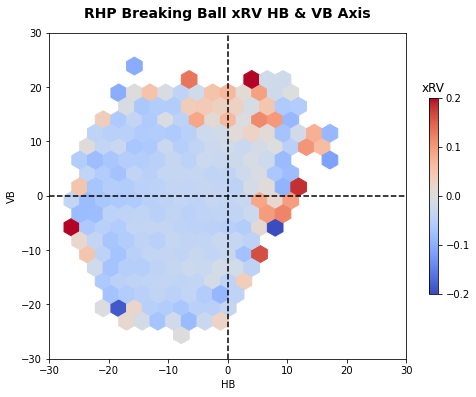

In [42]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_bb['pfx_x'], rhp_bb['pfx_z'], C = rhp_bb['xRV'],
                cmap='coolwarm', mincnt = 1, gridsize = 20)
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Breaking Ball xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);

## Off-Speed RHP

#### Changeup, Splitter

In [37]:
print('Baseline RHP Off-Speed RunValue Accuracy Score:', round(rhp_offspeed.rv.mean(), 2))

Baseline RHP Off-Speed RunValue Accuracy Score: -0.04


In [38]:
features_os_r = rhp_offspeed.select_dtypes([np.number])
X = features_os_r.drop(columns = ['rv'])
y = features_os_r['rv']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

rf = RandomForestRegressor(random_state = 1).fit(X_train, y_train)
pred_os_r = rf.predict(X_test)
pred = rf.predict(X)

print('R2 Score:', round((metrics.r2_score(y_test, pred_os_r)), 3))
print('Test RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, pred_os_r)), 3))
print('Test MAE:', round(metrics.mean_absolute_error(y_test, pred_os_r), 3), '\n')
print('R2 Score:', round((metrics.r2_score(y, pred)), 3))
print('RMSE:', round(np.sqrt(metrics.mean_squared_error(y, pred)), 3))
print('MAE:', round(metrics.mean_absolute_error(y, pred), 3))

R2 Score: -0.037
Test RMSE: 0.282
Test MAE: 0.166 

R2 Score: 0.632
RMSE: 0.168
MAE: 0.089


### RHP OS RV

In [ ]:
rhp_os = rhp_os.copy()
rhp_os['xRV'] = pred
rhp_os['xRV'] = round(rhp_os['xRV'], 3)
rhp_os['SL_count'] = [1 if x == 'CH' else 0 for x in rhp_os['pitch_type']]
rhp_os['CU_count'] = [1 if x == 'FS' else 0 for x in rhp_os['pitch_type']]

#feldman_os = 
#pred_feldman_os = rf.predict(feldman_os)
##columns = ['player_name', 'pitch_type', 'velo', 'spin_rate', 'HB', 'VB', 'release_pos_x', 'release_pos_z']
#feldman_rv_os = pd.DataFrame(data = feldman_os, columns = columns)
#feldman_os['xRV'] = pred_feldman_os
#feldman_os.head()

In [ ]:
#steinfort_os = 
#pred_steinfort_os = rf.predict(steinfort_os)
#steinfort_rv_os = pd.DataFrame(data = steinfort_os, columns = columns)
#steinfort_os['xRV'] = pred_steinfort_os
#steinfort_os.head()

### RHP Off-Speed xRV by HB & VB

RHP Off-Speed Avg xRunValue: -0.03


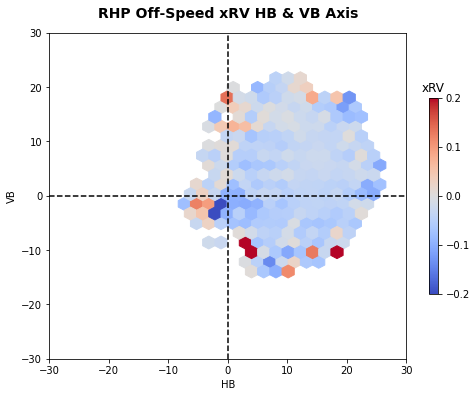

In [41]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
sns.scatterplot(data = feldman_os, x = 'HB', y = 'VB', hue = 'xRV', cmap = 'coolwarm_r')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('Feldman Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('RHP Off-Speed Avg xRunValue:', round(rhp_offspeed.xRV.mean(), 2))

In [ ]:
plt.figure(figsize = (8, 6))

ax = plt.hexbin(rhp_os['pfx_x'], rhp_os['pfx_z'], C = rhp_os['xRV'], cmap = 'coolwarm', 
           mincnt = 1, gridsize = 20)
sns.scatterplot(data = steinfort_os, x = 'HB', y = 'VB', hue = 'xRV', cmap = 'coolwarm_r')
cb = plt.colorbar(ax, ticks = [-.2,-.1, 0, .1, .2], shrink = .6)
cb.ax.set_title('xRV'), plt.clim(-.2, .2)
plt.xlabel('HB'), plt.ylabel('VB'), plt.xlim(-30, 30), plt.ylim(-30, 30)
plt.axhline(0, color = 'black', ls = '--'), plt.axvline(0, color = 'black', ls = '--')
plt.title('RHP Off-Speed xRV HB & VB Axis', fontsize = 14, fontweight = 'bold', pad = 15);
print('Steinfort Off-Speed Avg xRunValue:', round(rhp_offspeed.xRV.mean(), 2))